## 卷積神經網路（CNN）

### 資料擴增

### 撰寫繪製結果用的函數

先撰寫繪製結果用的函數，等等進行各種圖像操作的時候會用到

In [6]:
#1 繪製結果用的函數
import matplotlib.pyplot as plt

def draw(X):
    plt.figure(figsize=(8, 8))
    pos = 1

    # 把每張圖像繪製出來
    for i in range(X.shape[0]):
        plt.subplot(4, 4, pos)
        plt.imshow(X[i].reshape((28,28)),interpolation='nearest')
        plt.axis('off')
        pos += 1
    plt.show()

### 前置動作

繼續使用相同的資料集，先和當時做一樣的資料處理

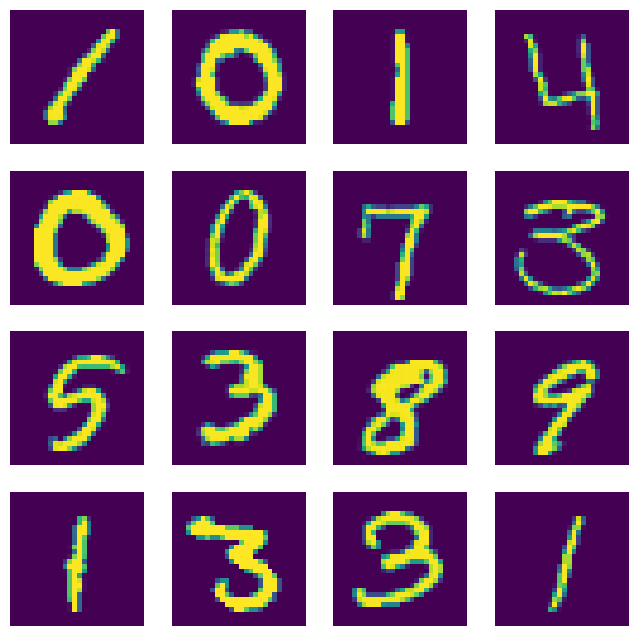

In [7]:
#2 前置動作
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

# 讀取資料集
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

# 提取x, y
tr_x = train.drop(['label'], axis=1)
train_y = train['label']

# 縮放x
tr_x = np.array(tr_x / 255.0)

# 將x轉換大小
tr_x = tr_x.reshape(-1,28,28,1)

# 對y編碼
tr_y = to_categorical(train_y, 10)

# 用於測試的圖像張數
batch_size = 16

draw(tr_x[0:batch_size])

我們可以先來試著對圖像進行一些操作並觀察結果看看

### 旋轉圖像

嘗試旋轉圖像

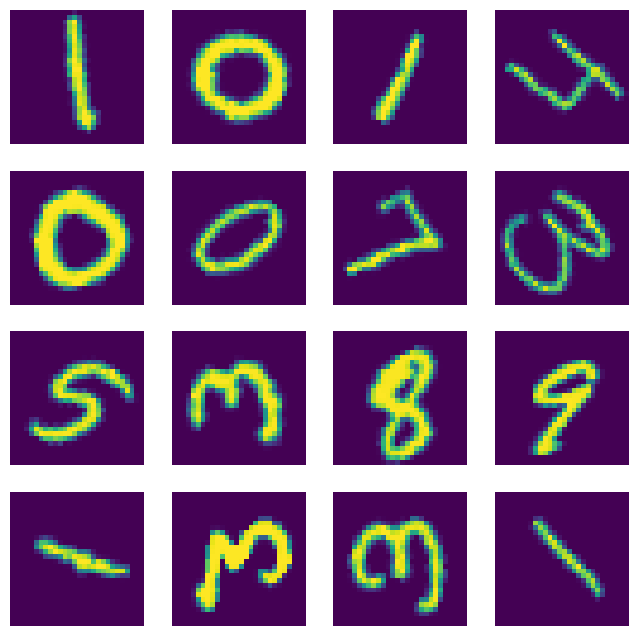

In [9]:
#3 旋轉圖像
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 旋轉圖像（最多90度）
datagen = ImageDataGenerator(rotation_range=90)
g = datagen.flow(tr_x, tr_y, batch_size, shuffle=False)
X_batch, y_batch = next(g)
draw(X_batch)

### 平移圖像

將圖像左右、上下移動

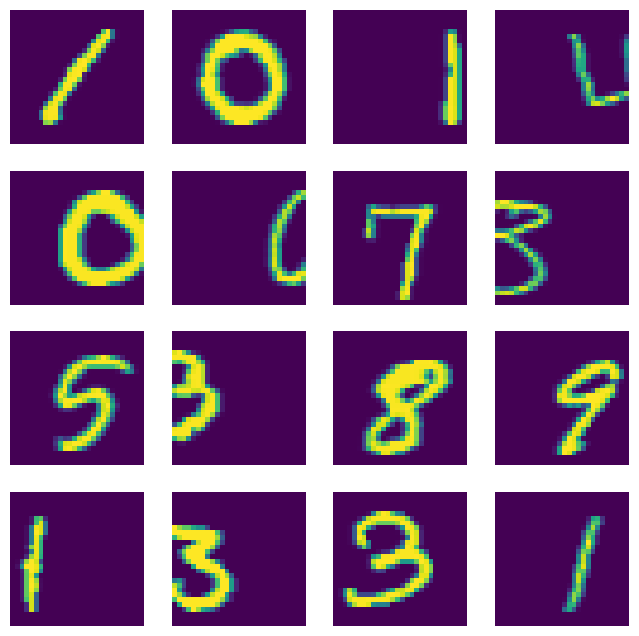

In [12]:
#4 左右移動
# 左右移動（最大0.5）
datagen = ImageDataGenerator(height_shift_range=0.5)
g = datagen.flow(tr_x, tr_y, batch_size, shuffle=False)
X_batch, y_batch = next(g)
draw(X_batch)

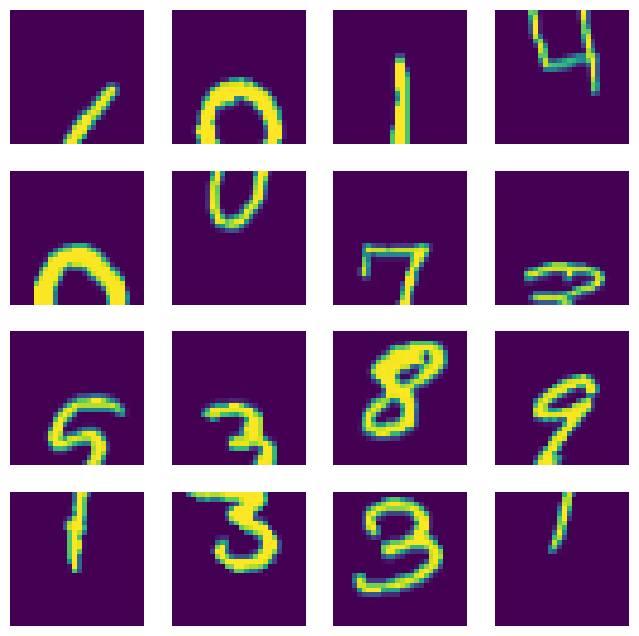

In [10]:
#5 上下移動
# 上下移動（最大0.5）
datagen = ImageDataGenerator(width_shift_range=0.5)
g = datagen.flow(tr_x, tr_y, batch_size, shuffle=False)
X_batch, y_batch = next(g)
draw(X_batch)

### 縮放圖像

將圖像放大

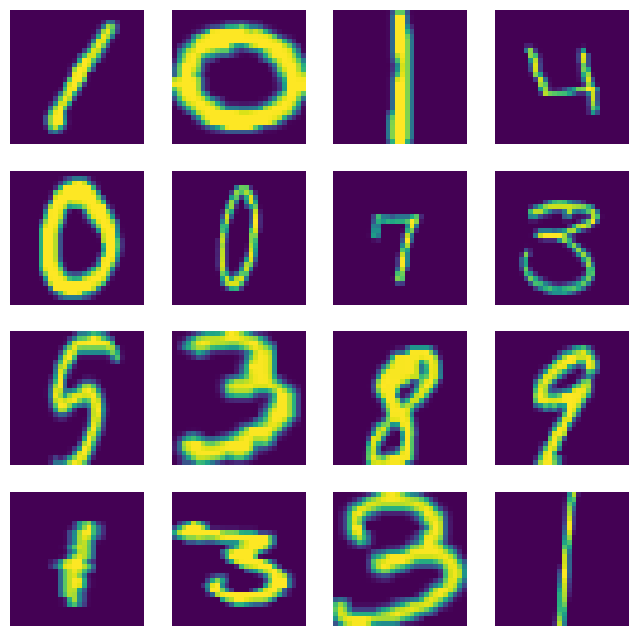

In [13]:
#6 放大圖像
# 放大圖像（最大0.5）
datagen = ImageDataGenerator(zoom_range=0.5)
g = datagen.flow(tr_x, tr_y, batch_size, shuffle=False)
X_batch, y_batch = next(g)
draw(X_batch)

### 翻轉圖像

將圖像左右、上下翻轉

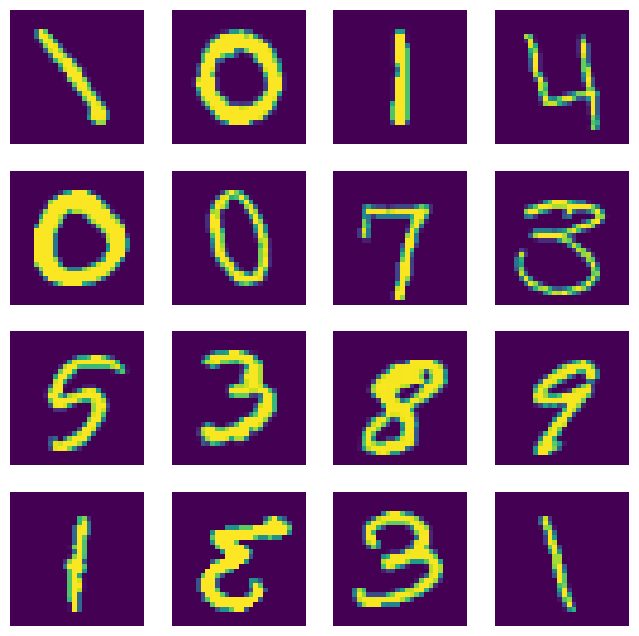

In [14]:
#7 左右翻轉
# 左右翻轉圖像
datagen = ImageDataGenerator(horizontal_flip=True)
g = datagen.flow(tr_x, tr_y, batch_size, shuffle=False)
X_batch, y_batch = next(g)
draw(X_batch)

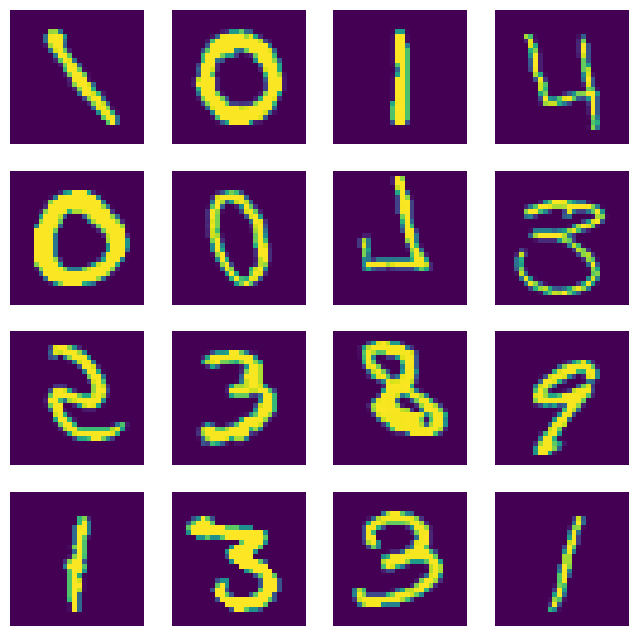

In [15]:
#8 上下翻轉
# 上下翻轉圖像
datagen = ImageDataGenerator(vertical_flip=True)
g = datagen.flow(tr_x, tr_y, batch_size, shuffle=False)
X_batch, y_batch = next(g)
draw(X_batch)

接著正式把資料擴增這個技巧用到神經網路中

### 重置資料

重新載入資料

In [16]:
#9 重製資料
# 重新載入資料集
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_x = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# 提取x, y
train_x = train.drop(['label'], axis=1)
train_y = train['label']

# 分割資料集
kf = KFold(n_splits=4, shuffle=True, random_state=123)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# 縮放x
tr_x, va_x = np.array(tr_x / 255.0), np.array(va_x / 255.0)

# 改變x大小
tr_x = tr_x.reshape(-1,28,28,1)
va_x = va_x.reshape(-1,28,28,1)

# 對y編碼
tr_y = to_categorical(tr_y, 10)
va_y = to_categorical(va_y, 10)

### 建立模型

建立神經網路模型

In [18]:
#9 建立模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input

model = Sequential()
model.add(Input(shape=(28,28,1)))

# 第1層 卷積層
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu',))

# 第2層 卷積層
model.add(Conv2D(filters = 64,
                 kernel_size = (7,7),
                 padding='same',
                 activation='relu'))

# 第3層 池化層
model.add(MaxPooling2D(pool_size=(2,2)))

# 設定drop out
model.add(Dropout(0.5))

# 第4層 卷積層
model.add(Conv2D(filters=64,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

# 第5層 卷積層
model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding='same',
                 activation='relu'))

# 第6層 池化層
model.add(MaxPooling2D(pool_size=(2,2)))

# 設定drop out
model.add(Dropout(0.55))

# 展平層
model.add(Flatten())

#第7層 全連接層
model.add(Dense(700, activation='relu'))
model.add(Dropout(0.3))

#第8層 全連接層
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.35))

#第10層 輸出層
model.add(Dense(10, activation = "softmax"))

# 編譯模型
momentum = 0.5
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

### 擴增資料並用於訓練神經網路

用`fit_generator()`進行擴增資料並拿來訓練神經網路

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 資料擴增
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=10,
                             zoom_range=0.1)

batch_size = 100
epochs = 20

# 進行訓練
history = model.fit(datagen.flow(tr_x, tr_y, batch_size=batch_size),
                    steps_per_epoch=tr_x.shape[0] // batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(va_x,va_y))

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9849 - loss: 0.0547 - val_accuracy: 0.9920 - val_loss: 0.0265
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9834 - loss: 0.0609 - val_accuracy: 0.9934 - val_loss: 0.0229
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9848 - loss: 0.0537 - val_accuracy: 0.9939 - val_loss: 0.0211
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9865 - loss: 0.0475 - val_accuracy: 0.9910 - val_loss: 0.0278
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9840 - loss: 0.0527 - val_accuracy: 0.9930 - val_loss: 0.0249
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9841 - loss: 0.0586 - val_accuracy: 0.9938 - val_loss: 0.0203
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9835 - loss: 0.0542 - val_accuracy: 0.9943 - val_loss: 0.0217
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9859 - loss: 0.0498 - 

可以發現：
- 經過簡單的擴增資料，驗證集的準確度就來到了99.46%